In [ ]:
#Importing relevant libraries (subject to change!)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn as sk

In [ ]:
#Mounting the drive to allow for importing and use of data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Reading and verifying the table and information to ensure everything works and is proper
data_table = pd.read_csv("/content/gdrive/MyDrive/CS 4641 Summer 22/high_diamond_ranked_10min.csv")
print("The dimensions of our dataset: " + str(data_table.shape))
data_table.head()

The dimensions of our dataset: (9879, 40)


gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   

   redTowersDestroyed  redTotalGold  redAvgLevel  redTotalExperience  \
0                   0         16567          6.8               17047   
1                   1         17620          6.8               17438   
2                   0         17285          6.8               17254   
3                   0         16478          7.0               17961   
4                   0         17404          7.0               18313   

   redTotalMinionsKilled  redTotalJungleMinionsKilled  redGoldDiff  \
0                    197                           55         -643   
1                    240                           52         2908   
2                    203                           28         1172   
3                    235                           47         1321   
4                    225                           67         1004   

   redExperienceDiff  redCSPerMin  redGoldPerMin  
0                  8         19.7         1656.7  
1               1173         24.0         1762.0  
2               1033         20.3         1728.5  
3                  7         23.5         1647.8  
4               -230         22.5         1740.4  

[5 rows x 40 columns]

## **Data Cleaning and Initial Exploration**

We should clean and explore our data before using it! We will proceed to remove insignificant columns (like gameId) that are not relevant to our cause, and then single out a team to get a better look at our data. Then, we will plot the features against each other and create a heatmap to visualize how our data relates to each other in terms of their features.

In [ ]:
#Drop the gameId column and then pull out only the statistics from the blue team.
target = data_table['blueWins']
blue = data_table.drop(['gameId'], axis=1).filter(like='blue')

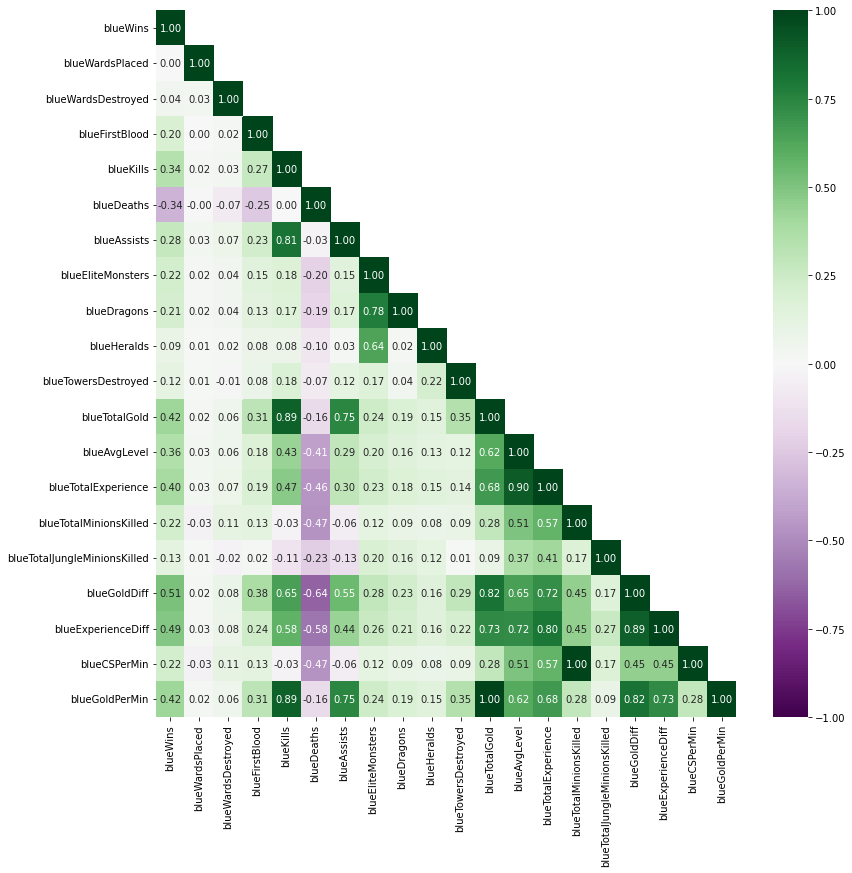

In [ ]:
plt.figure(figsize = (13, 13))
upper_tri = np.triu(blue.corr())
np.fill_diagonal(upper_tri, False)
sns.heatmap(blue.corr(), vmin=-1, vmax=1, mask=upper_tri, annot=True, fmt='.2f', cmap='PRGn')

Looking at this initial heatmap, we would be good to remove some of these features. The reasons being are:
1.   Computational efficiency increases with less features
2.   ~~Some features have little correlations with any other features~~ **(removed due to midterm feedback)**
3.   To avoid colinearity, we want to avoid including features with a very high correlation, which is 0.9.

Let's remove these features! Note, we want to keep our gameWins column, as these will be our target values when we begin supervised learning (and where colinearity becomes a bigger issue).

Even though total gold and kills are tightly related, within the context of *League of Legends*, it would be weird not to have kills included, as the KDA (Kill-Death-Assist) Ratio would not make sense. So, we will leave it here for completeness!




In [ ]:
blue_clean = blue.drop(['blueEliteMonsters', 'blueWins', 'blueCSPerMin', 'blueGoldPerMin', 'blueGoldDiff', 'blueAvgLevel'], axis=1)

Explanation on the choice of features selected:

*   ~~*Wards Placed and Wards Destroyed*: These features were barely correlated with any of the other features, so removing them will save computation time.~~ **(Included due to midterm feedback)**
*   *Elite Monsters*: Heralds and Dragons are both elite monsters, so they don't need to all be represented in this dataset. It's important to know that these monsters are on *opposite* sides of the map, hence giving more information than just elite monsters killed.
*   *Wins*: This feature will be important to us later when we do supervised learning, but for right now, it's unneeded.
*   *CS and Gold per Minute*: Because it's the first 10 minutes of the game, it's redundant to have these features, since we can extrapolate it by doing our own math!
*   *Gold Diff*: We aren't necessarily overly concerned with the red team's data at the moment, but this feature was very correlated with Experience Diff, and so I do not think both of these features are needed in our dataset. Only one is needed to illustrate the difference in resources the teams have.
*   *Average Level*: This was a feature that was strongly correlated with total Experience, so we removed it from our feature set.







Let's look at our new heatmap!

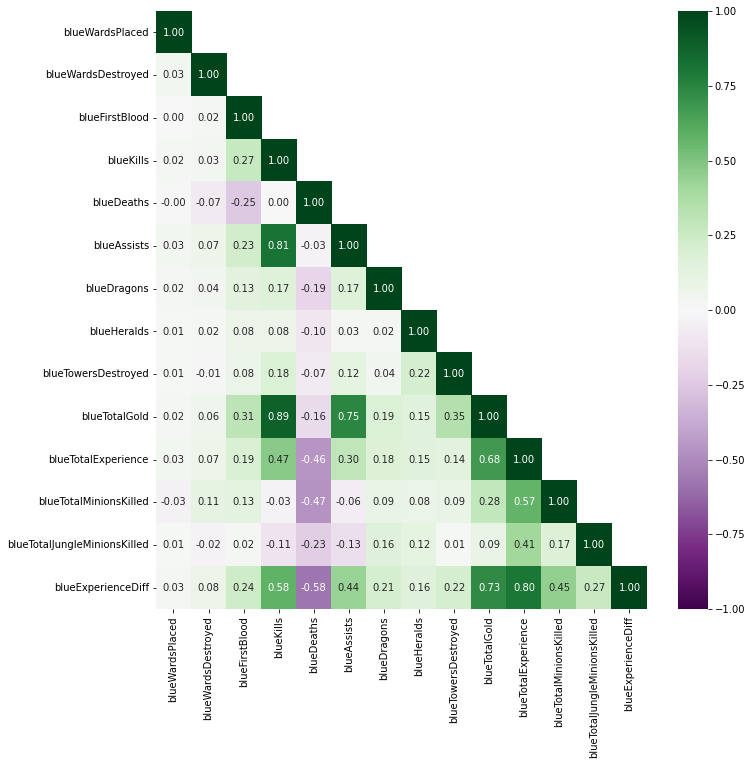

In [ ]:
#Create a heat map to explore the correlation of the features
plt.figure(figsize = (11, 11))
upper_tri = np.triu(blue_clean.corr())
np.fill_diagonal(upper_tri, False)
sns.heatmap(blue_clean.corr(), vmin=-1, vmax=1, mask=upper_tri, annot=True, fmt='.2f', cmap='PRGn')

We were able to knock down some features, but we still have quite a bit more than we probably need. Time for dimensionality reduction!

## **Unsupervised Learning: Principal Component Analysis, Manifold Learning (t-SNE and Isomap), and Clustering (K-Means, Gaussian Mixture Model)**

# Principal Component Analysis on the Dataset

Let's assemble our PCA for our dataset. We first need to tend to our dataset by centering the data, as well as scaling it so we are on a standard range of [0, 1]. However, we have also included the non-normalized dataset and included it in our t-SNE and PCA analyses. This way we can see a more tangible and real product in our models.

In [ ]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

np.set_printoptions(suppress=True)
scaled_blue = preprocessing.scale(blue_clean)

NOTE: There is also no PC0, it is only here to visualize the 0% retained variance, as there must be an equal amount of X and Y values to plot onto the graph.

In [ ]:
#Non-Normalized PCA
pca2 = PCA()
pca2.fit(blue_clean)
blue_reduced_nn = pca2.transform(blue_clean)

[0, 84.07, 94.63, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99]


Text(0.5, 1.0, 'Explained Variance By PC, Non-Normalized')

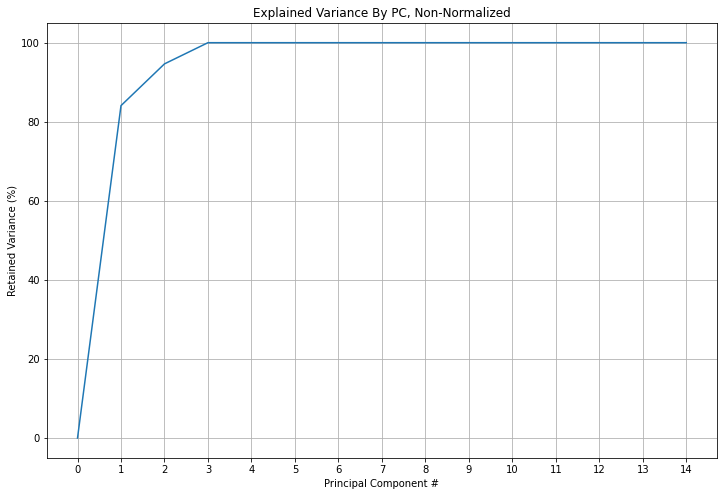

In [ ]:
var_nn = np.round(pca2.explained_variance_ratio_ * 100, decimals=2)
labels_nn = []
lab_num_nn = [0]
sum_var_nn = [0]
sum = 0


for v in var_nn:
  sum += v
  sum_var_nn.append(sum)
for i in range(1, len(var_nn) + 1):
  lab_num_nn.append(i)
  labels_nn.append('PC ' + str(i))

print(sum_var_nn)
plt.figure(figsize = (12, 8))
sns.lineplot(x = lab_num_nn, y = sum_var_nn)
plt.xticks(lab_num_nn)
plt.grid()
plt.ylabel('Retained Variance (%)')
plt.xlabel('Principal Component #')
plt.title('Explained Variance By PC, Non-Normalized')

In [ ]:
#Normalized PCA
pca = PCA()
pca.fit(scaled_blue)
blue_reduced = pca.transform(scaled_blue)

[0, 30.15, 44.62, 52.86, 60.25, 67.55, 74.53, 81.12, 86.9, 91.9, 95.89, 97.97, 98.97, 99.76, 99.99000000000001]


Text(0.5, 1.0, 'Explained Variance By PC, Normalized')

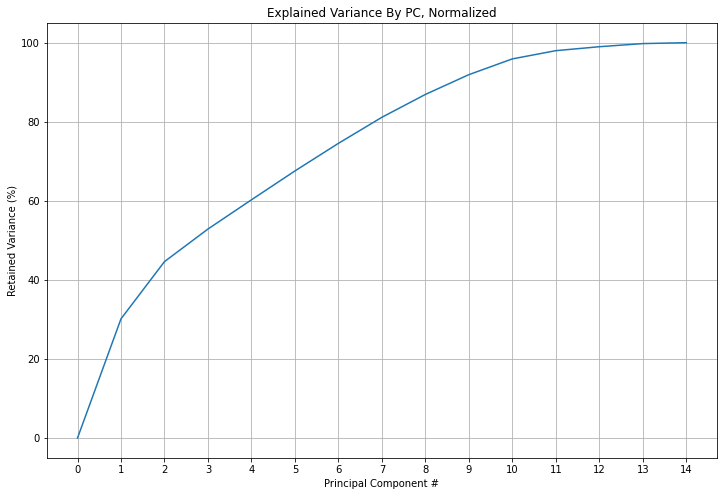

In [ ]:
var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = []
lab_num = [0]
sum_var = [0]
sum = 0


for v in var:
  sum += v
  sum_var.append(sum)
for i in range(1, len(var) + 1):
  lab_num.append(i)
  labels.append('PC ' + str(i))


print(sum_var)
plt.figure(figsize = (12, 8))
sns.lineplot(x = lab_num, y = sum_var)
plt.xticks(lab_num)
plt.grid()
plt.ylabel('Retained Variance (%)')
plt.xlabel('Principal Component #')
plt.title('Explained Variance By PC, Normalized')

Non-Normalized:
Most of the variance is covered within the first 2 PCs, with ~95%. The thing for us to look into from this is to find which features are the most relevant to the PCs.

Normalized:
After normalizing the data, most of the features are covered through the first 3 PCs at around 53%, with 96% covered through 10 PCs. This is a considerable difference compared to our non-normalized data, which was expected.

Looking more in depth, we can actually observe which features within the 2 Principal Components are the most important. We include the 3rd PC mostly for completeness, although it does not tell us anything new.

In [ ]:
print(abs(pca2.components_[0:3]))

[[0.00020473 0.00006673 0.00005489 0.00085595 0.00054978 0.00089262
  0.00004132 0.00002682 0.00002585 0.53382218 0.41693488 0.00399747
  0.00103172 0.73564955]
 [0.00020102 0.00003599 0.00008089 0.0018225  0.00168166 0.00245629
  0.00000252 0.00000356 0.00006548 0.84331953 0.19886908 0.00542706
  0.00294967 0.49921225]
 [0.00032896 0.0000129  0.00004796 0.00071168 0.0002432  0.00134288
  0.0000155  0.00000466 0.00004676 0.06180014 0.88681788 0.01022079
  0.004876   0.45782537]]


The breakdown is as follows:
*   PC 1: Features 10, 11, and 14 are the most important, and these correspond to totalGold (0.534), totalExperience (0.417), and experienceDiff (0.736).
*   PC 2: Yet again, totalGold (0.843) and experienceDiff(0.499) are the 2 dominant features in this principal component. totalExperience only pulled a 0.20 score, not very high.
*   PC 3: Interestingly, only totalExperience (0.887) and experienceDiff (0.458) are the most important features in the 3rd PC.

From this data, we can extrapolate that gathering an experience lead, accompanied by a high gold count, will contribute to these PCs. When we plot them, we will have a much clearer intuition as to what is the driving factor between a win and a loss.




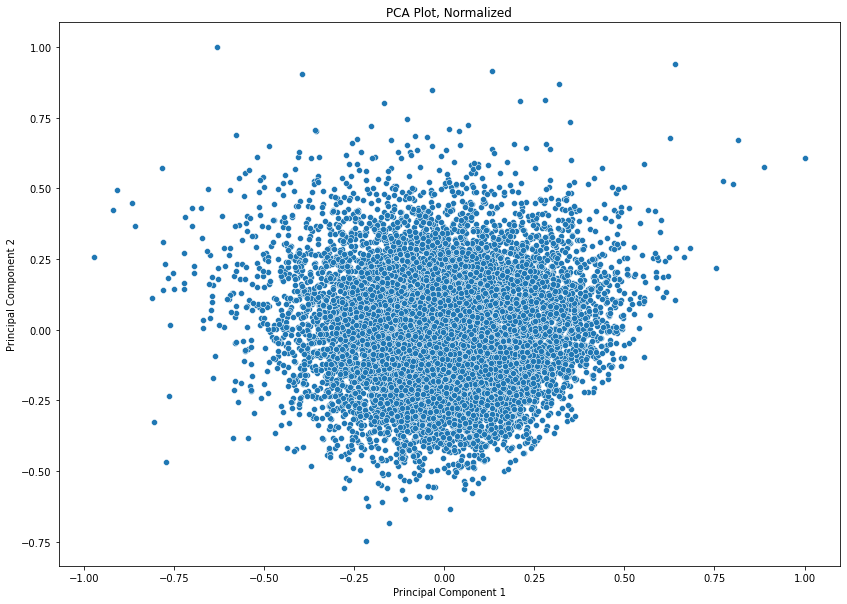

In [ ]:
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('PCA Plot, Normalized')
sns.scatterplot(
    x=blue_reduced[:,0] / blue_reduced[:,0].max(), 
    y=blue_reduced[:,1] / blue_reduced[:,1].max()
)

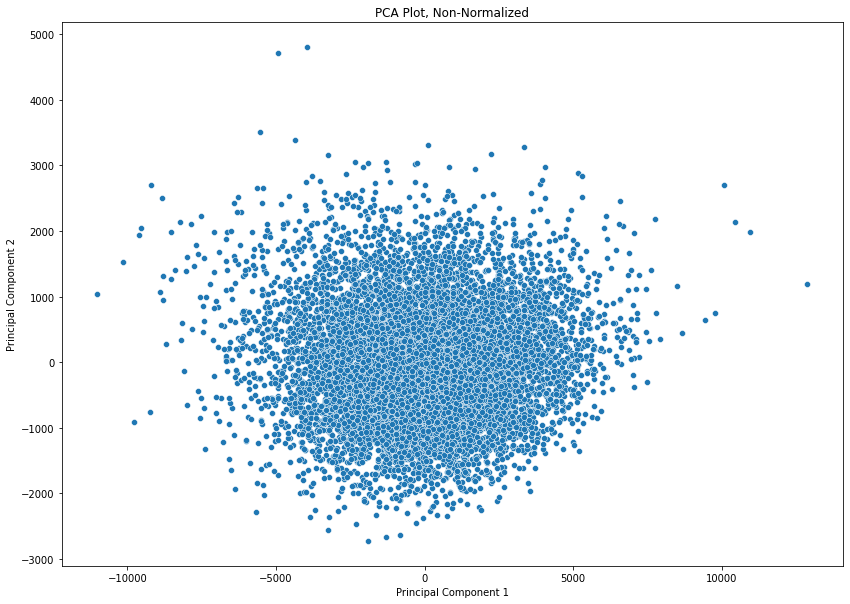

In [ ]:
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('PCA Plot, Non-Normalized')
sns.scatterplot(
    x=blue_reduced_nn[:,0], 
    y=blue_reduced_nn[:,1]
)

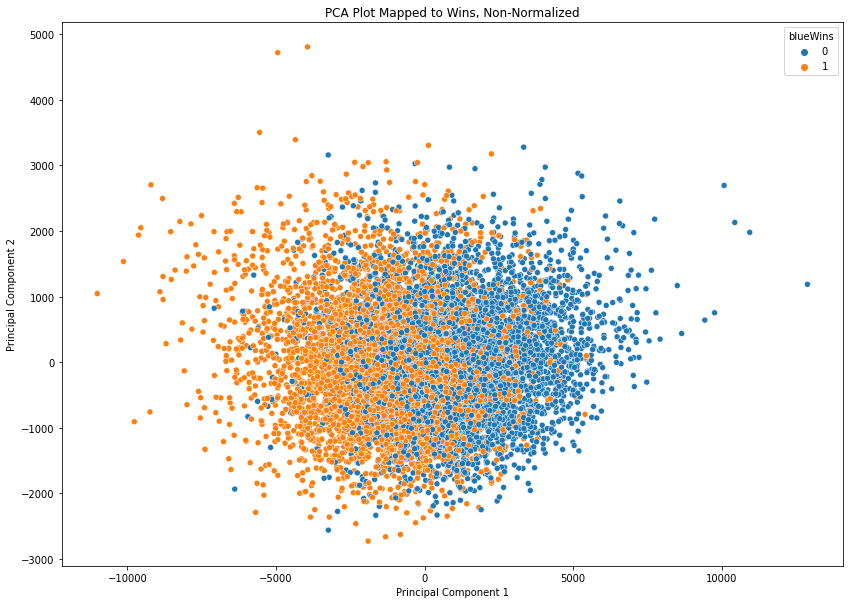

In [ ]:
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('PCA Plot Mapped to Wins, Non-Normalized')
sns.scatterplot(
    x=blue_reduced_nn[:,0], 
    y=blue_reduced_nn[:,1],
    hue=target
)

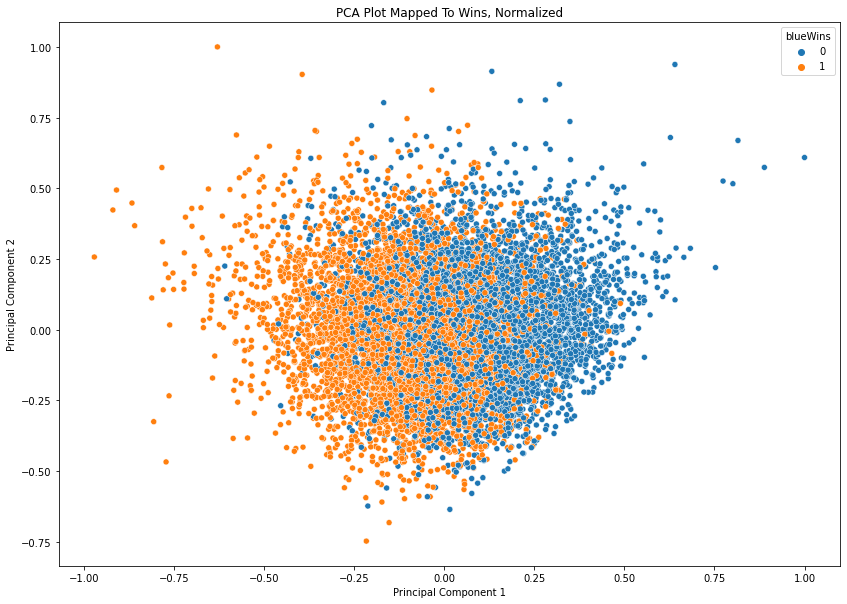

In [ ]:
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('PCA Plot Mapped To Wins, Normalized')
sns.scatterplot(
    x=blue_reduced[:,0] / blue_reduced[:,0].max(), 
    y=blue_reduced[:,1] / blue_reduced[:,1].max(),
    hue=target
)

# K-Means and GMM on the Dataset

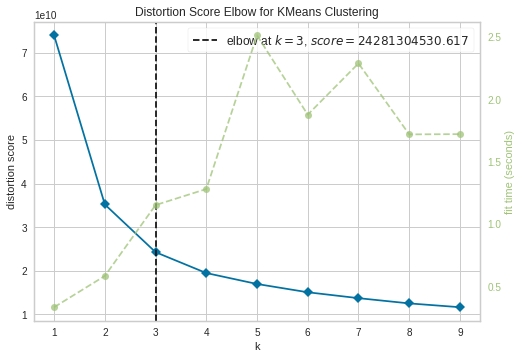

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
kmeans = KMeans()
elbows = KElbowVisualizer(kmeans, k=(1,10))

elbows.fit(blue_reduced_nn)
elbows.show()

Even though the elbow method suggests 3 clusters, I don't think that would make much sense with our dataset considering the target values imply a win or a loss. We will stick with 2 clusters.

Note: The labels in the clustering algorithms are NOT the same as the target values, from my knowledge.

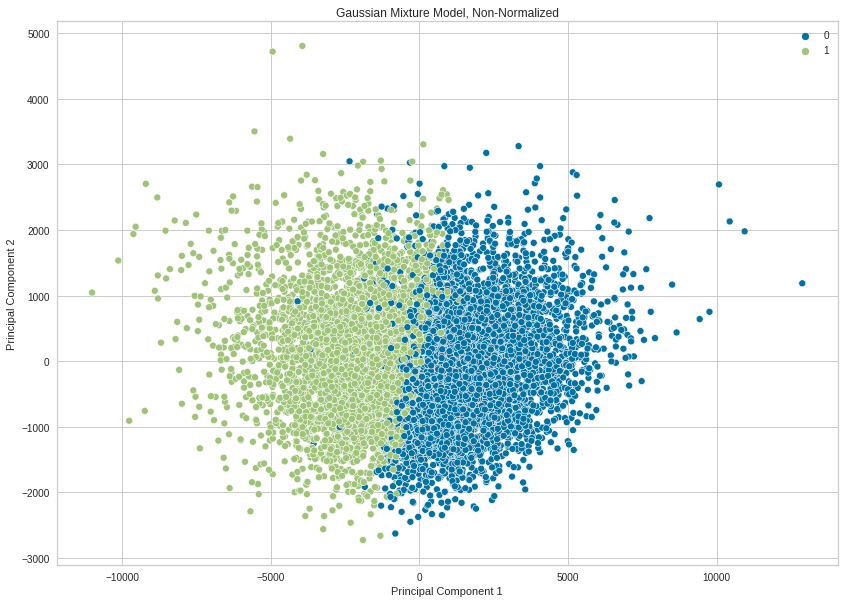

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='tied').fit(blue_reduced_nn)
gmm_labels = gmm.predict(blue_reduced_nn)
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('Gaussian Mixture Model, Non-Normalized')
sns.scatterplot(
    x=blue_reduced_nn[:, 0],
    y=blue_reduced_nn[:, 1],
    hue=gmm_labels
    );

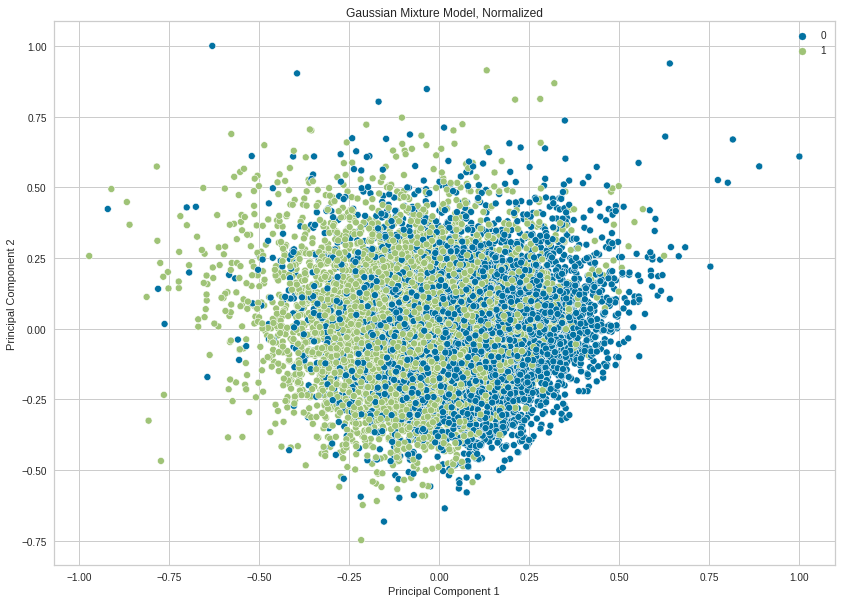

In [ ]:
gmm2 = GaussianMixture(n_components=2, covariance_type='tied').fit(blue_reduced)
gmm2_labels = gmm2.predict(blue_reduced)
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('Gaussian Mixture Model, Normalized')
sns.scatterplot(
    x=(blue_reduced[:, 0] / blue_reduced[:, 0].max()),
    y=(blue_reduced[:, 1] / blue_reduced[:, 1].max()),
    hue=gmm2_labels
    );

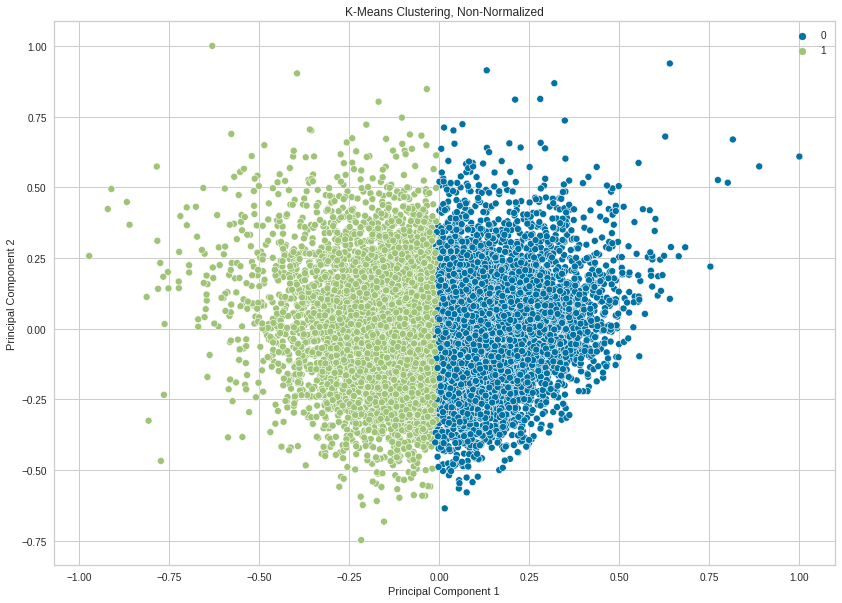

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans_labels = kmeans.fit(blue_reduced).predict(blue_reduced)
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('K-Means Clustering, Non-Normalized')
sns.scatterplot(
    x=(blue_reduced[:, 0] / blue_reduced[:, 0].max()),
    y=(blue_reduced[:, 1] / blue_reduced[:, 1].max()),
    hue=kmeans_labels
    );

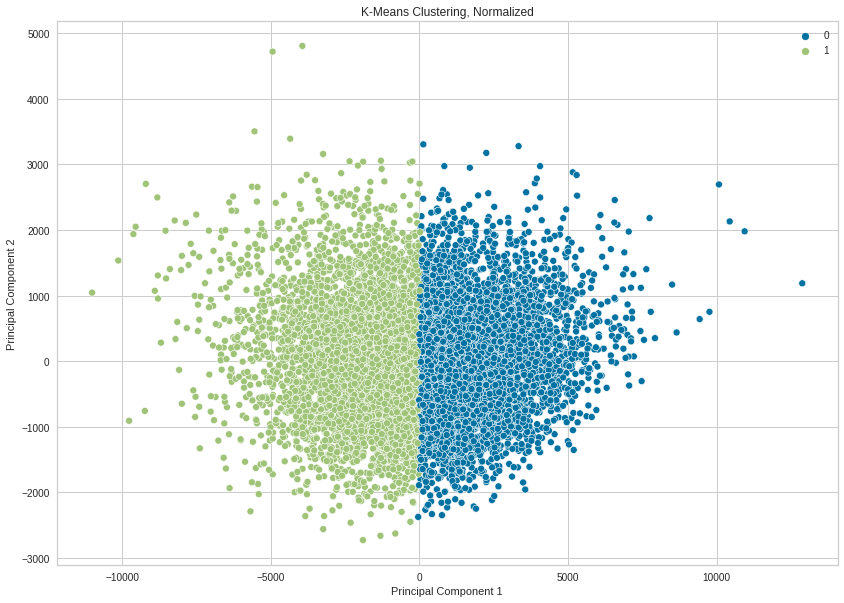

In [ ]:
kmeans2 = KMeans(n_clusters=2)
kmeans2_labels = kmeans2.fit(blue_reduced).predict(blue_reduced_nn)
plt.figure(figsize = (14, 10))
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.title('K-Means Clustering, Normalized')
sns.scatterplot(
    x=blue_reduced_nn[:, 0],
    y=blue_reduced_nn[:, 1],
    hue=kmeans2_labels
    );

We used GMM and K-Means in order to try and see a pattern in terms of how the data is separated separate from the target values. Because we expect either a win or loss from every game, 2 components seemed to make the most sense, even at the cost of a higher distortion value. 

The GMM (tied covariance) and K-Means clustering actually came out very similarly in terms of how the games were clustered in terms of the non-normalized data. However, once normalization occurred, only K-Means retained it's structure, and GMM became much harder to discern compared to its non-normalized counterpart.

# Clustering Evaluation (F1-Measure, Fowlkes-Mallows, Jaccard, Davies-Bouldin)

In [ ]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

rand_eval = [rand_score(target, gmm_labels), rand_score(target, gmm2_labels), rand_score(target, kmeans_labels), rand_score(target, kmeans2_labels)]
fm_eval = [fowlkes_mallows_score(target, gmm_labels), fowlkes_mallows_score(target, gmm2_labels), fowlkes_mallows_score(target, kmeans_labels), fowlkes_mallows_score(target, kmeans2_labels)]
jaccard_eval = [jaccard_score(target, gmm_labels), jaccard_score(target, gmm2_labels), jaccard_score(target, kmeans_labels), jaccard_score(target, kmeans2_labels)]
f1_eval = [f1_score(target, gmm_labels), f1_score(target, gmm2_labels), f1_score(target, kmeans_labels), f1_score(target, kmeans2_labels)]


eval_table = {'F1': f1_eval,
           'Rand': rand_eval,
           'Fowlkes-Mallows': fm_eval,
           'Jaccard': jaccard_eval}
eval_df = pd.DataFrame(eval_table, index=['Gaussian Mixture', 'Gaussian Mixture (Normalized)', 'K-Means', 'K-Means (Normalized)'])
eval_df.style.set_properties(**{'text-align': 'center'})
eval_df.style.background_gradient(axis=1, cmap='Spectral', vmin=0.3, vmax=0.8)

We used Rand, Fowlkes-Mallows, and Jaccard, as these are all techniques we used in class to evaluate clustering. Specifically, they are a good measure of inter-cluster performance, discerning between wins and losses.

We used F1 measure to quantify overall accuracy and precision, covering the percentage of games we felt were mostly deserved wins and losses compared to the actual wins and losses mapped to the data.

Overall, these measures mostly measured up to our expectations. K-Means did a better job overall of classification of wins and losses than GMM, and given this is what we concluded from our Touchpoint, it's nice to have some tangible quantifications as to the performance of our metrics.





# Manifold Learning with t-SNE and Isomap

t-SNE is also another dimensionality reduction tool we can use to further explore and visualize our data.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


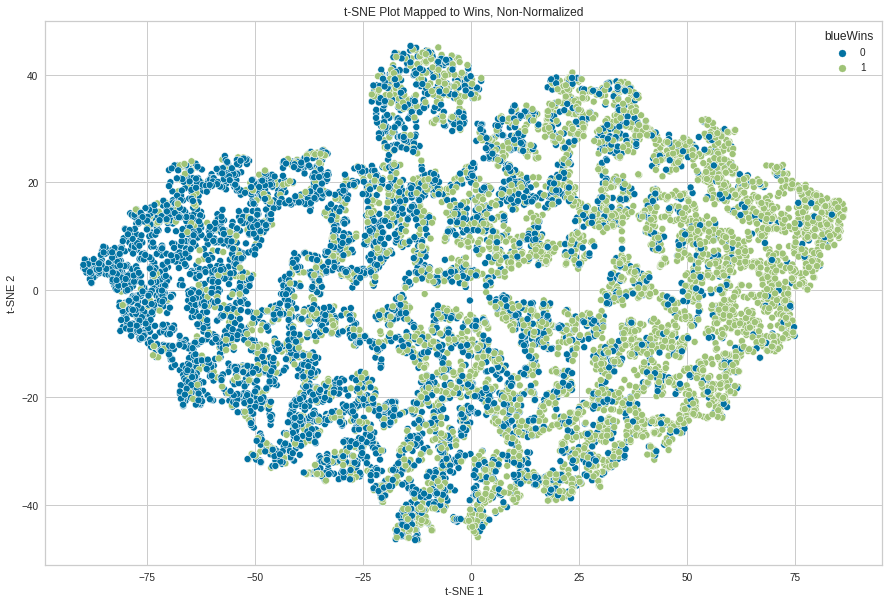

In [ ]:
from sklearn.manifold import TSNE

tsne2 = TSNE(n_components=2,
            perplexity=70)

blue_tsne_nn = tsne2.fit_transform(blue_reduced_nn)
plt.figure(figsize = (15, 10))
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Plot Mapped to Wins, Non-Normalized')
sns.scatterplot(
    x=blue_tsne_nn[:,0],
    y=blue_tsne_nn[:,1],
    hue=blue['blueWins']
)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


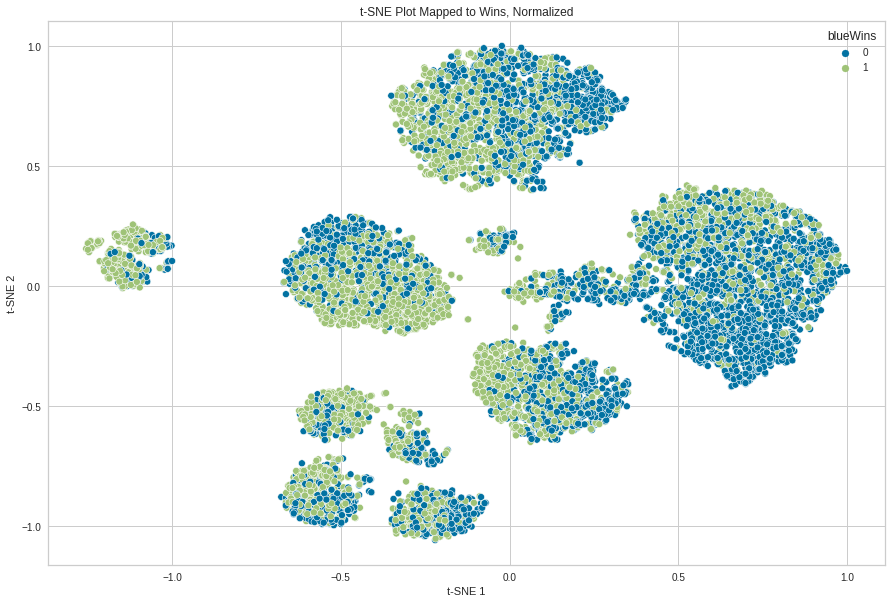

In [ ]:
tsne = TSNE(n_components=2,
            init='pca',
            perplexity=70)
blue_tsne = tsne.fit_transform(blue_reduced)
plt.figure(figsize = (15, 10))
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Plot Mapped to Wins, Normalized')
sns.scatterplot(
    x=blue_tsne[:,0] / blue_tsne[:,0].max(), 
    y=blue_tsne[:,1] / blue_tsne[:,1].max(),
    hue=blue['blueWins']
)



For the non-normalized data, there was virtually no difference between the PCA initialized tSNE and the actual PCA plot, so I decided to initialize to a random seed.

Both the normalized and non-normalized models both show some separation of components. While it isn't as much as I would have hoped, there are still some indicators of themed clustering. For instance, our normalized model generated clusters with some inner separation. That may be something to look more into in the future. t-SNE doesn't give us the insight into the feature importance that we want, unlike PCA.

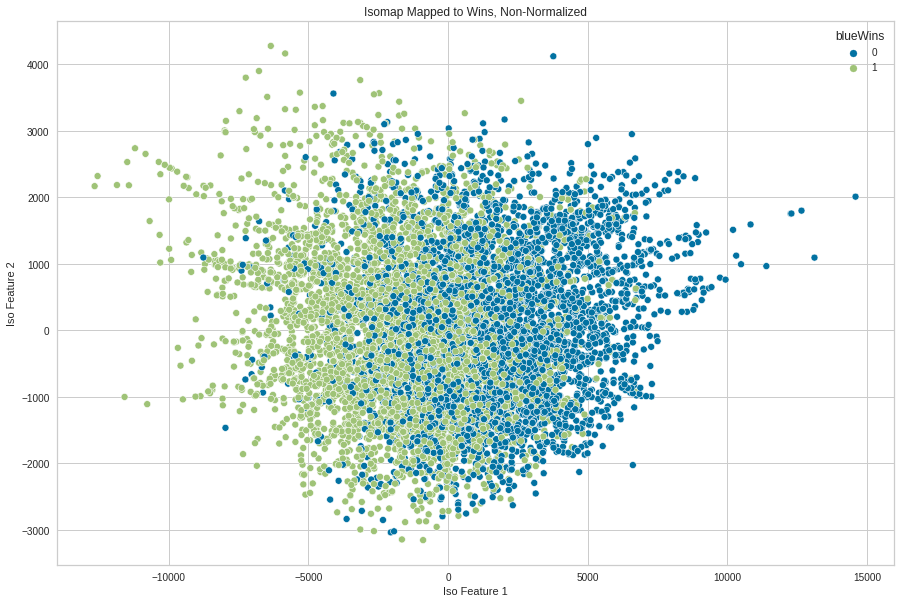

In [ ]:
from sklearn import manifold

isomap = manifold.Isomap(n_components=2)
isomap.fit(blue_reduced_nn)
blue_iso_nn = isomap.transform(blue_reduced_nn)
plt.figure(figsize = (15, 10))
plt.xlabel('Iso Feature 1')
plt.ylabel('Iso Feature 2')
plt.title('Isomap Mapped to Wins, Non-Normalized')
sns.scatterplot(
    x=blue_iso_nn[:,0],
    y=blue_iso_nn[:,1],
    hue=blue['blueWins']
)

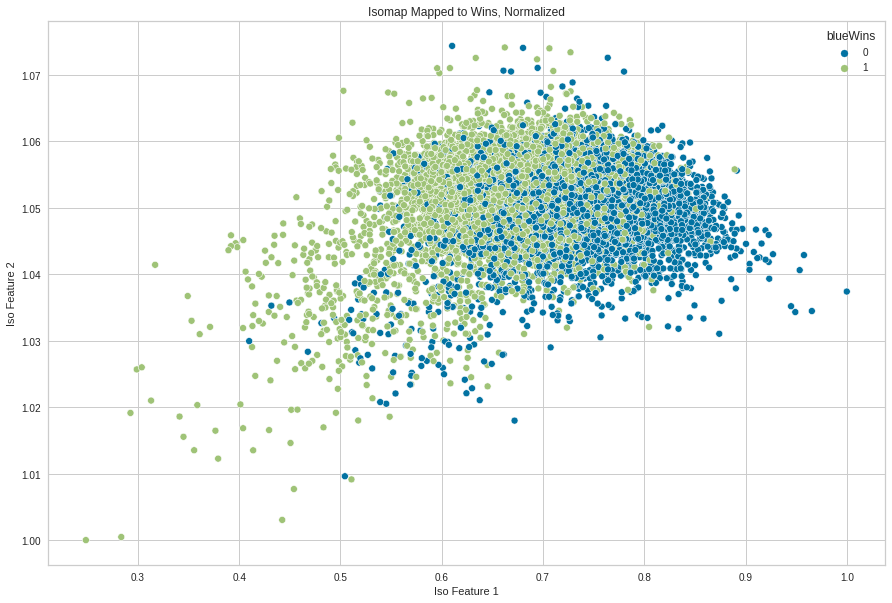

In [ ]:
isomap2 = manifold.Isomap(n_components=2)
isomap2.fit(blue_reduced)
blue_iso = isomap.transform(blue_reduced)
plt.figure(figsize = (15, 10))
plt.xlabel('Iso Feature 1')
plt.ylabel('Iso Feature 2')
plt.title('Isomap Mapped to Wins, Normalized')
sns.scatterplot(
    x=blue_iso[:,0] / blue_iso[:,0].max(),
    y=blue_iso[:,1] / blue_iso[:,1].max(),
    hue=blue['blueWins']
)

The Isomap embedding has also shown separation in the dataset, as predicted based off of our PCA and t-SNE models. It's interesting to see the normalized vs the non-normalized data in terms of the shape and the outliers. There is a huge, dense clump in the upper right center, while there seems to be more outliers on the edges in the normalized dataset.

Overall, we have explored our dataset, cleaned up the data, and used PCA, t-SNE, and the isomap embedding to visualize our data. We observed the retained variance in our data, and we have shown it by mapping our target values to the values of both the t-SNE plot and the PCA plot. We also compared our PCA plot to a GMM model, comparing the two for completeness.

##Supervised Learning: Support Vector Machines

We will explore a supervised learning technique: Support Vector Machines. But first, we need to separate our data into a testing set and a training set. Let's remind ourselves of the datasets we will use.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
blue_clean.head()

blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  blueKills  blueDeaths  \
0               28                   2               1          9           6   
1               12                   1               0          5           5   
2               15                   0               0          7          11   
3               43                   1               0          4           5   
4               75                   4               0          6           6   

   blueAssists  blueDragons  blueHeralds  blueTowersDestroyed  blueTotalGold  \
0           11            0            0                    0          17210   
1            5            0            0                    0          14712   
2            4            1            0                    0          16113   
3            5            0            1                    0          15157   
4            6            0            0                    0          16400   

   blueTotalExperience  blueTotalMinionsKilled  blueTotalJungleMinionsKilled  \
0                17039                     195                            36   
1                16265                     174                            43   
2                16221                     186                            46   
3                17954                     201                            55   
4                18543                     210                            57   

   blueExperienceDiff  
0                  -8  
1               -1173  
2               -1033  
3                  -7  
4                 230

We are now going to downsample this data to around 2,000 datapoints, because cross-validating ~10,000 datapoints is a massive pain, and will take way too long. We also want to try and optimally create our SVM. For this, we will actually use the original dataset, and then remove the features that we removed in our blue_clean dataset.

Let's acquire 1,000 games where the blue team won, and 1,000 where they did not win!

In [ ]:
blue_win = blue[blue['blueWins'] == 1]
blue_loss = blue[blue['blueWins'] == 0]

blue_win_downsampled = resample(blue_win, replace=False, n_samples=1000)
blue_loss_downsampled = resample(blue_loss, replace=False, n_samples=1000)
blue_downsampled = pd.concat([blue_win_downsampled, blue_loss_downsampled])

X = blue_downsampled.drop(['blueEliteMonsters', 'blueWins', 'blueCSPerMin', 'blueGoldPerMin', 'blueGoldDiff', 'blueAvgLevel'], axis=1).copy()
y = blue_downsampled['blueWins'].copy()

In [ ]:
X.head()

blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  blueKills  \
4815               11                   0               0          3   
3965               16                   2               1         12   
2016               18                   3               0          5   
3484               17                   5               0          3   
5914               14                   1               1          5   

      blueDeaths  blueAssists  blueDragons  blueHeralds  blueTowersDestroyed  \
4815           6            2            0            1                    0   
3965          10           10            1            1                    1   
2016           5           10            1            0                    0   
3484           6            4            1            0                    0   
5914           6            4            0            0                    0   

      blueTotalGold  blueTotalExperience  blueTotalMinionsKilled  \
4815          14106                15716                     200   
3965          20065                18844                     204   
2016          16138                16397                     208   
3484          14513                16872                     202   
5914          16481                18268                     221   

      blueTotalJungleMinionsKilled  blueExperienceDiff  
4815                            48               -1004  
3965                            71                3068  
2016                            54                -813  
3484                            52                -368  
5914                            53               -1127

In [ ]:
y.head()

4815    1
3965    1
2016    1
3484    1
5914    1
Name: blueWins, dtype: int64

Support Vector Machines work best with continuous forms of data. Because the only form of categorical data we have is First Blood (we did or did not get first blood), we should look to encode this data so that it can be reasonable compared with other features. Leaving the data in its categorical state will not allow for the features to be interpreted in a realistic way. The SVM will categorize the first blood data with other datapoints that can be appropriately grouped when treated continously, so let's do that.

In [ ]:
X_encoded = pd.get_dummies(X, columns=['blueFirstBlood'])
X_encoded.head()

blueWardsPlaced  blueWardsDestroyed  blueKills  blueDeaths  blueAssists  \
4815               11                   0          3           6            2   
3965               16                   2         12          10           10   
2016               18                   3          5           5           10   
3484               17                   5          3           6            4   
5914               14                   1          5           6            4   

      blueDragons  blueHeralds  blueTowersDestroyed  blueTotalGold  \
4815            0            1                    0          14106   
3965            1            1                    1          20065   
2016            1            0                    0          16138   
3484            1            0                    0          14513   
5914            0            0                    0          16481   

      blueTotalExperience  blueTotalMinionsKilled  \
4815                15716                     200   
3965                18844                     204   
2016                16397                     208   
3484                16872                     202   
5914                18268                     221   

      blueTotalJungleMinionsKilled  blueExperienceDiff  blueFirstBlood_0  \
4815                            48               -1004                 1   
3965                            71                3068                 0   
2016                            54                -813                 1   
3484                            52                -368                 1   
5914                            53               -1127                 0   

      blueFirstBlood_1  
4815                 0  
3965                 1  
2016                 0  
3484                 0  
5914                 1

Now we create our training and evaluation sets.

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(X_encoded, y)
X_train_scaled = preprocessing.scale(X_train)
X_eval_scaled = preprocessing.scale(X_eval)

Now we are ready to make our Support Vector Machine! We will use a Gaussian/Radial Basis Function kernel, as it seems to best fit our needs given our dataset. Per Andrew Ng, it's a good idea to use Gaussian kernel when observations > features. We will also evaluate the initial performance by creating a confusion matrix.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


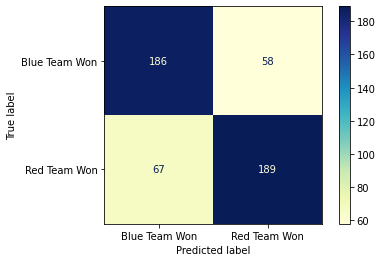

In [ ]:
SVM = SVC(kernel='rbf')
SVM.fit(X_train_scaled, y_train)
plot_confusion_matrix(SVM, X_eval_scaled, y_eval, cmap='YlGnBu', values_format='d', display_labels=["Blue Team Won", "Red Team Won"])

This means that of all the games where the blue team won, 186 games out of 244 (76.23%) were properly classified as a win. Of the games where the red team won, 189 games out of 256 (73.82%) were properly classified. That's fine, but can we do better? Let's optimize our SVM.

In [ ]:
parameter_grid = [
    {'C': [0.5, 1, 5, 10, 50, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

optimal = GridSearchCV(SVC(), parameter_grid, scoring='accuracy')
optimal.fit(X_train_scaled, y_train)
print(optimal.best_params_)

{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


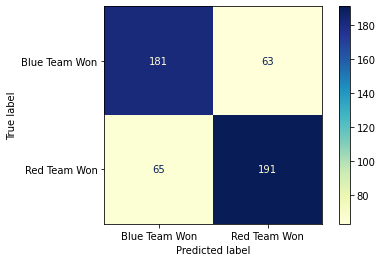

In [ ]:
SVM = SVC(C=5, gamma=0.01, kernel='rbf')
SVM.fit(X_train_scaled, y_train)
plot_confusion_matrix(SVM, X_eval_scaled, y_eval, cmap='YlGnBu', values_format='d', display_labels=["Blue Team Won", "Red Team Won"])

Given this, the amount of correctly labeled blue team wins actually dropped by 5, and the correctly labeled red team wins increased by 2. What this says to me is that the SVM is fairly optimized, even in its preliminary state. I feel this is because of how close the datapoints are to each other in the distribution.

Even with the optimizations to our SVM, we still virtually have the same percentage of effectiveness. Now, we should look to apply PCA on this dataset (remember this has not been reduced due to how we got our data). This way, we can visualize the SVM and see the decision boundaries.

In [ ]:
svm_pca = PCA(n_components=2)
X_train_pca = svm_pca.fit_transform(X_train_scaled)
pc1 = X_train_pca[:, 0]
pc2 = X_train_pca[:, 1]
X_train_pca_scaled = preprocessing.scale(np.column_stack((pc1, pc2)))

Now we follow the same procedure as before, generating an SVM for our data reduced by PCA.

In [ ]:
parameter_grid = [
    {'C': [0.5, 1, 5, 10, 50, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]
optimal = GridSearchCV(SVC(), parameter_grid, scoring='accuracy')
optimal.fit(X_train_pca_scaled, y_train)
print(optimal.best_params_)

SVM = SVC(C=0.5, gamma='scale')
model = SVM.fit(X_train_pca_scaled, y_train)

{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}


Now we fit the evaluation dataset to PCA and we will visualize it. Reminder that the whole reason that we did this is that we can visualize our data and decision boundaries.

In [ ]:
X_eval_pca = svm_pca.transform(X_eval_scaled)
eval_pc1 = X_eval_pca[:, 0]
eval_pc2 = X_eval_pca[:, 1]

In order to properly visualize our boundary, we need to input it in a function, which we will use here. Credit for this function goes to Serafeim Loukas!

<Figure size 1080x1080 with 0 Axes>

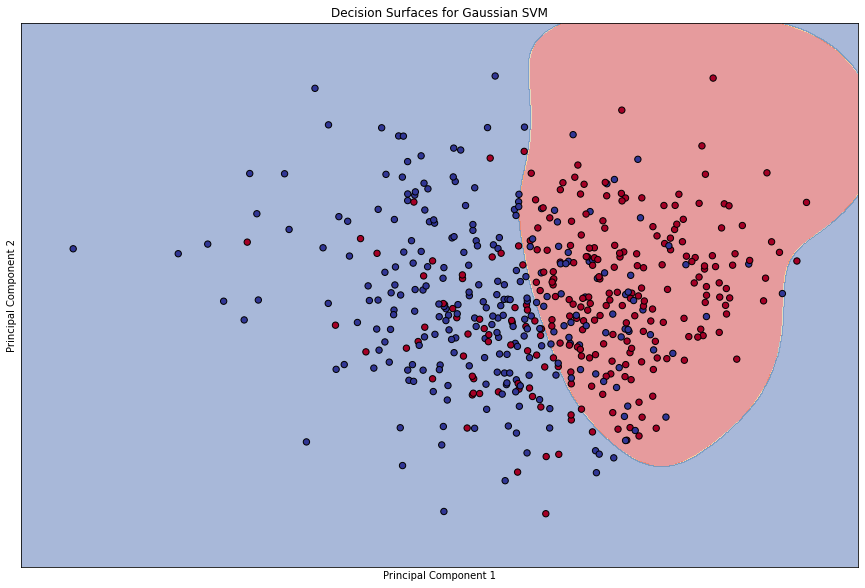

In [ ]:
from matplotlib.colors import ListedColormap
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

plt.figure(figsize = (15, 15))
fig, ax = plt.subplots()
# title for the plots
title = ('Decision Surfaces for Gaussian SVM')
# Set-up grid for plotting.
xx, yy = make_meshgrid(eval_pc1, eval_pc2)

plot_contours(ax, SVM, xx, yy, cmap=plt.cm.RdYlBu, alpha=0.45)
ax.scatter(eval_pc1, eval_pc2, c=y_eval, cmap=plt.cm.RdYlBu, s=40, edgecolors="k")
ax.set_ylabel('Principal Component 2')
ax.set_xlabel('Principal Component 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
fig.set_figwidth(15)
fig.set_figheight(10)
plt.show()

As you can see, the decision boundary has been made and shown. The SVM did an okay job, as indicated by our prior accuracy rating. Most of the red team wins are in the red decision region, and the blue team wins are in the blue decision region. This is a pretty solid classification, albeit it does have more misclassifications than I would like. With further analysis, one could deduce which games are throws and which games are comebacks, but also, the dataset is pretty condensed. Our Gaussian kernel came in huge here, as the data was not going to be linearly separable, and that was indicated in our unsupervised learning exploration too, hence why we did not use a linear or polynomial kernel.

In [ ]:
blue_clean.head()

blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  blueKills  blueDeaths  \
0               28                   2               1          9           6   
1               12                   1               0          5           5   
2               15                   0               0          7          11   
3               43                   1               0          4           5   
4               75                   4               0          6           6   

   blueAssists  blueDragons  blueHeralds  blueTowersDestroyed  blueTotalGold  \
0           11            0            0                    0          17210   
1            5            0            0                    0          14712   
2            4            1            0                    0          16113   
3            5            0            1                    0          15157   
4            6            0            0                    0          16400   

   blueTotalExperience  blueTotalMinionsKilled  blueTotalJungleMinionsKilled  \
0                17039                     195                            36   
1                16265                     174                            43   
2                16221                     186                            46   
3                17954                     201                            55   
4                18543                     210                            57   

   blueExperienceDiff  
0                  -8  
1               -1173  
2               -1033  
3                  -7  
4                 230

In [ ]:
blue_encoded = pd.get_dummies(blue_clean, columns=['blueFirstBlood'])
blue_encoded.head()

blueWardsPlaced  blueWardsDestroyed  blueKills  blueDeaths  blueAssists  \
0               28                   2          9           6           11   
1               12                   1          5           5            5   
2               15                   0          7          11            4   
3               43                   1          4           5            5   
4               75                   4          6           6            6   

   blueDragons  blueHeralds  blueTowersDestroyed  blueTotalGold  \
0            0            0                    0          17210   
1            0            0                    0          14712   
2            1            0                    0          16113   
3            0            1                    0          15157   
4            0            0                    0          16400   

   blueTotalExperience  blueTotalMinionsKilled  blueTotalJungleMinionsKilled  \
0                17039                     195                            36   
1                16265                     174                            43   
2                16221                     186                            46   
3                17954                     201                            55   
4                18543                     210                            57   

   blueExperienceDiff  blueFirstBlood_0  blueFirstBlood_1  
0                  -8                 0                 1  
1               -1173                 1                 0  
2               -1033                 1                 0  
3                  -7                 1                 0  
4                 230                 1                 0

In [ ]:
target

0       0
1       0
2       0
3       0
4       0
       ..
9874    1
9875    1
9876    0
9877    0
9878    1
Name: blueWins, Length: 9879, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


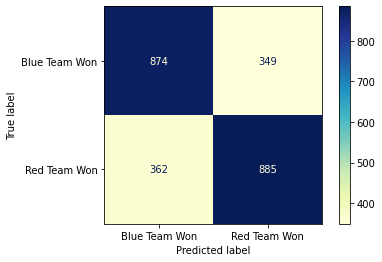

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(blue_encoded, target)
X_train_scaled = preprocessing.scale(X_train)
X_eval_scaled = preprocessing.scale(X_eval)

SVM = SVC(C=5, gamma=0.01, kernel='rbf')
SVM.fit(X_train_scaled, y_train)
plot_confusion_matrix(SVM, X_eval_scaled, y_eval, cmap='YlGnBu', values_format='d', display_labels=["Blue Team Won", "Red Team Won"])

In [ ]:
parameter_grid = [
    {'C': [0.5, 1, 5, 10, 50, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

optimal = GridSearchCV(SVC(), parameter_grid, scoring='accuracy')
optimal.fit(X_train_scaled, y_train)
print(optimal.best_params_)

{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


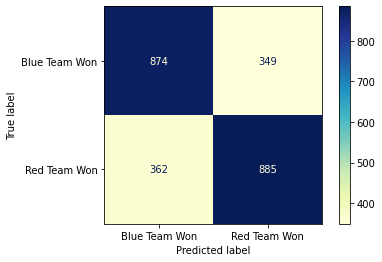

In [ ]:
SVM = SVC(C=5, gamma=0.01, kernel='rbf')
SVM.fit(X_train_scaled, y_train)
plot_confusion_matrix(SVM, X_eval_scaled, y_eval, cmap='YlGnBu', values_format='d', display_labels=["Blue Team Won", "Red Team Won"])